## Import Modules

In [58]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [59]:
BASE_DIR = '/kaggle/input/flickr8k/'
WORKING_DIR = '/kaggle/working'

## Extract Image Features

In [60]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [63]:
# store features in pickle
pickle.dump(features, open(os.path.join('features.pkl'), 'wb'))

In [64]:
# load features from pickle
with open(os.path.join('features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load the Captions Data

In [127]:
with open(os.path.join('caption-modified.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [128]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/5863 [00:00<?, ?it/s]

In [129]:
mapping

{'1000268201_693b08cb0e': [" What color is the child's dress in the image?",
  ' What is the girl doing in the image?',
  ' What is the building made of where the girl is going?',
  ' What is the little girl climbing into?',
  ' What material is the playhouse made of?',
  ' What is the little girl doing?',
  ' Where is the little girl heading to?',
  ' What is the color of the dress the little girl is wearing?',
  ' What is the little girl entering into?'],
 '1001773457_577c3a7d70': [' What color is the dog that is fighting with the spotted dog?',
  ' Are the dogs in the picture playing or fighting?',
  ' What colors are the two dogs playing on the road?',
  ' Where are the two dogs playing?',
  ' What colors are the two dogs in the picture?',
  ' What are the dogs doing in the street?',
  ' What are the dogs doing on the road?',
  ' Are the dogs of the same breed?',
  ' Are the two dogs moving towards each other?',
  ' Are the dogs on a pavement?'],
 '1002674143_1b742ab4b8': [' What i

## Preprocess Text Data

In [130]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [131]:
# before preprocess of text
mapping['10815824_2997e03d76']

[' What color is the horse in the picture?',
 ' What are the horse and the girl staring at?',
 " What color is the girl's sweatshirt?",
 ' What is the fire contained in?',
 ' Who is standing by the fire?',
 ' What is the girl standing next to by the fire?',
 " Why is the girl holding the horse's lead behind a fire?",
 ' Is the girl trying to keep the horse away from the fire?',
 ' Who is closer to the fire  the man or the girl?',
 ' Are the horses near the fire?',
 ' What are the two people and two horses doing?',
 ' What are the two people and two horses watching?']

In [132]:
# preprocess the text
clean(mapping)

In [133]:
# after preprocess of text
mapping['10815824_2997e03d76']

['startseq what color is the horse in the picture? endseq',
 'startseq what are the horse and the girl staring at? endseq',
 "startseq what color is the girl's sweatshirt? endseq",
 'startseq what is the fire contained in? endseq',
 'startseq who is standing by the fire? endseq',
 'startseq what is the girl standing next to by the fire? endseq',
 "startseq why is the girl holding the horse's lead behind fire? endseq",
 'startseq is the girl trying to keep the horse away from the fire? endseq',
 'startseq who is closer to the fire the man or the girl? endseq',
 'startseq are the horses near the fire? endseq',
 'startseq what are the two people and two horses doing? endseq',
 'startseq what are the two people and two horses watching? endseq']

In [134]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [135]:
len(all_captions)

5862

In [136]:
all_captions[:10]

["startseq what color is the child's dress in the image? endseq",
 'startseq what is the girl doing in the image? endseq',
 'startseq what is the building made of where the girl is going? endseq',
 'startseq what is the little girl climbing into? endseq',
 'startseq what material is the playhouse made of? endseq',
 'startseq what is the little girl doing? endseq',
 'startseq where is the little girl heading to? endseq',
 'startseq what is the color of the dress the little girl is wearing? endseq',
 'startseq what is the little girl entering into? endseq',
 'startseq what color is the dog that is fighting with the spotted dog? endseq']

In [137]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [138]:
vocab_size

1955

In [139]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

22

## Train Test Split

In [140]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [141]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [142]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

In [143]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [144]:
# train the model
epochs = 20
batch_size = 16
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

30/30 [==============================] - 20s 662ms/step - loss: 1.2186


In [145]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

## Generate Captions for the Image

In [146]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [147]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [148]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/55 [00:00<?, ?it/s]

BLEU-1: 0.758092
BLEU-2: 0.579911


## Visualize the Results

In [153]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join( "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq what color is the horse in the picture? endseq
startseq what are the horse and the girl staring at? endseq
startseq what color is the girl's sweatshirt? endseq
startseq what is the fire contained in? endseq
startseq who is standing by the fire? endseq
startseq what is the girl standing next to by the fire? endseq
startseq why is the girl holding the horse's lead behind fire? endseq
startseq is the girl trying to keep the horse away from the fire? endseq
startseq who is closer to the fire the man or the girl? endseq
startseq are the horses near the fire? endseq
startseq what are the two people and two horses doing? endseq
startseq what are the two people and two horses watching? endseq
--------------------Predicted--------------------
startseq what are the girl and girl doing in the image endseq


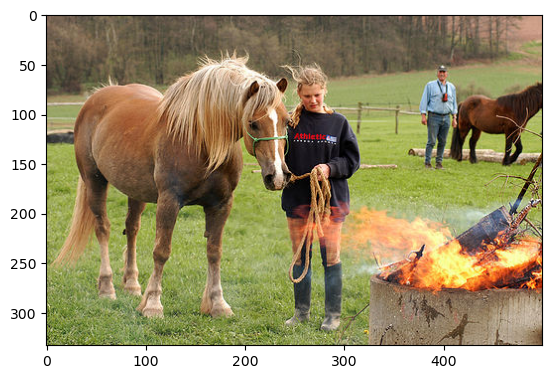

In [154]:
generate_caption("10815824_2997e03d76.jpg")

---------------------Actual---------------------
startseq what color is the child's dress in the image? endseq
startseq what is the girl doing in the image? endseq
startseq what is the building made of where the girl is going? endseq
startseq what is the little girl climbing into? endseq
startseq what material is the playhouse made of? endseq
startseq what is the little girl doing? endseq
startseq where is the little girl heading to? endseq
startseq what is the color of the dress the little girl is wearing? endseq
startseq what is the little girl entering into? endseq
--------------------Predicted--------------------
startseq what is the girl entering in the image endseq


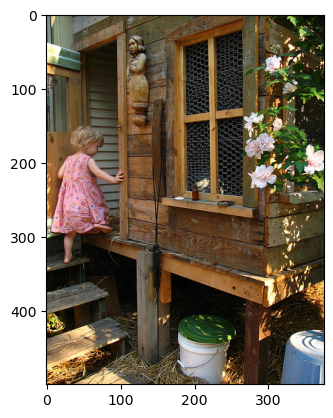

In [155]:
generate_caption("1000268201_693b08cb0e.jpg")

---------------------Actual---------------------
startseq how many children are walking down the road? endseq
startseq what color are the school uniforms the children are wearing? endseq
startseq what is the gender ratio of the children? endseq
startseq what is the condition of the road the children are walking on? endseq
startseq how many girls are in the group? endseq
startseq what color are the uniforms the children are wearing? endseq
startseq where are the children in the picture heading to? endseq
startseq what are the children wearing in the picture? endseq
startseq what is the background of the picture where the children are standing? endseq
startseq what are the teens wearing as they walk down the road? endseq
startseq what kind of road are the teens walking down? endseq
startseq what color are the school uniforms of the children in the picture? endseq
startseq are the children in the picture wearing individual outfits or uniforms? endseq
--------------------Predicted---------

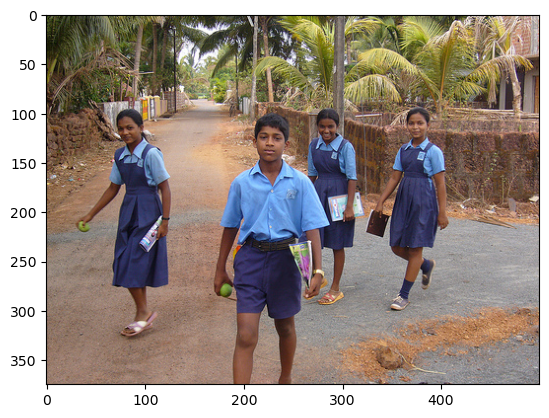

In [157]:
generate_caption("146098876_0d99d7fb98.jpg")

## Test with Real Image

In [158]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [160]:
image_path = 'Images/110595925_f3395c8bd6.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq what is the man doing on the mountain bike endseq'